# Compound Events Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import warnings
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap

warnings.filterwarnings('ignore')

In [2]:
nuts21 = gpd.read_file("./data/NUTS_RG_20M_2021_3035.shp")
nuts3 = nuts21[nuts21["LEVL_CODE"]==3]

## Process Exposure Data

In [3]:
expo = pd.read_csv("./data/asset_total_202503181032.csv", sep=';')
expo = expo.pivot_table(index=['administrative_unit_code', 'asset_year'], columns='asset', values='asset_total', fill_value=0)
expo.reset_index(inplace=True)
expo = expo.rename(columns={"administrative_unit_code":"NUTS_ID", "asset_year":"Year", "bui-occ-gen":"General_build", "bui-occ-res":"Residential_build", "sec-pop-gen":"Population"})[["NUTS_ID", "Year", "General_build","Residential_build", "Population"]]	
expo.columns.name = None
expo.set_index(['NUTS_ID', 'Year'], inplace=True)
all_years = np.arange(1975, 2031)

expo_interpolated = []

# Iterate over each NUTS_ID group
for nuts_id, group in expo.groupby(level='NUTS_ID'):
    # Create a new index for this group with all years
    idx = pd.MultiIndex.from_product([[nuts_id], all_years], names=['NUTS_ID', 'Year'])
    
    # Reindex the group to include all years, then interpolate
    group_reindexed = group.reindex(idx).interpolate(method='linear')
    
    # Append the reindexed and interpolated group to the results list
    expo_interpolated.append(group_reindexed)

# Concatenate all the groups back into a single DataFrame
expo_interpolated = pd.concat(expo_interpolated)

# Reset index if you need 'NUTS_ID' and 'Year' as columns
expo_interpolated.reset_index(inplace=True)


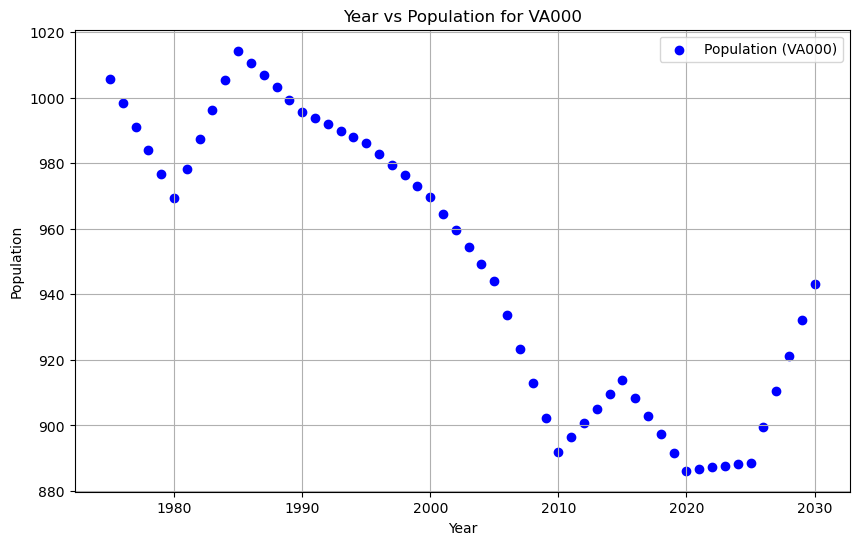

In [4]:
nuts_id = 'VA000'
data_to_plot = expo_interpolated[expo_interpolated['NUTS_ID'] == nuts_id]
plt.figure(figsize=(10, 6))
plt.scatter(data_to_plot['Year'], data_to_plot['Population'], color='b', label=f'Population ({nuts_id})')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title(f'Year vs Population for {nuts_id}')
plt.legend()
plt.grid(True)
plt.show()

## Create ML ready dataset

In [5]:
attr = pd.read_csv("./data/Attribution_losses_with_RP.csv")
attr = attr.rename(columns={"HANZE_ID":"eventID"})
attr = attr.rename(columns={'NUTS3':"NUTS_ID"})

In [6]:
multihz = pd.read_csv("../data/CompoundEventsXHanze_v21.csv", encoding='ISO-8859-1')
multihz = multihz.rename(columns={'NUTl':"NUTS_ID", 'ï..ID':'eventID', 'drought.n':'predrought', 'flood.n':'preflood', 
                                  'HW.n':'preheat', 'CW.n':'precold', 'WS.n':'prewind', 'Persons.affected':"AffectedPop", 
                                  'Area.flooded':"Area", 'Losses..2020.euro.':"Losses", 'drought.i':"intdrought",
                                  'flood.i':"intflood", 'WS.i':"intwind", 'CW.i':"intcold", 'HW.i':"intheat",
                                  'drought.lag':"lagdrought", 'flood.lag':'lagflood', 'HW.lag':'lagheat', 
                                  'CW.lag':'lagcold', 'WS.lag':'lagwind'})
multihz = pd.merge(multihz, attr[["eventID", "NUTS_ID", 'ReturnPeriod']], on = ["eventID", "NUTS_ID"], how="left")
multihz = multihz[['Year', 'eventID', 'NUTS_ID', 'Fatalities', 'AffectedPop', 'Area', 'Losses', 'predrought', "lagdrought", "intdrought",
                   'preflood', 'lagflood', "intflood", 'prewind', 'lagwind', 'intwind', 'preheat', 'lagheat', 'intheat', 
                   'precold', 'lagcold', 'intcold', 'ReturnPeriod']]

In [7]:
multihz.columns

Index(['Year', 'eventID', 'NUTS_ID', 'Fatalities', 'AffectedPop', 'Area',
       'Losses', 'predrought', 'lagdrought', 'intdrought', 'preflood',
       'lagflood', 'intflood', 'prewind', 'lagwind', 'intwind', 'preheat',
       'lagheat', 'intheat', 'precold', 'lagcold', 'intcold', 'ReturnPeriod'],
      dtype='object')

In [8]:
def fill_na_with_group_mean(group):
    mean_value = group['ReturnPeriod'].mean()
    group['ReturnPeriod'] = group['ReturnPeriod'].fillna(mean_value)
    return group

multihz['ReturnPeriod'] = multihz.groupby('NUTS_ID')['ReturnPeriod'].transform(lambda x: x.fillna(x.mean()))
multihz['ReturnPeriod'] = multihz.groupby('eventID')['ReturnPeriod'].transform(lambda x: x.fillna(x.mean()))

In [9]:
multihz[['predrought','preflood', 'prewind',  'preheat', 'precold']] = multihz[['predrought', 'preflood', 'prewind',  'preheat','precold',]].fillna(0)

In [10]:
vi = pd.read_csv("./data/vulnerability/VI_nuts3.csv")

In [11]:
medium_nuts = multihz
medium_nutsvi = medium_nuts.merge(vi, on=["Year", "NUTS_ID"], how='left')
medium_nutsvi_exp = pd.merge(medium_nutsvi, expo_interpolated, on=["Year", "NUTS_ID"], how="left")
mean_cols = ['AffectedPop', 'Area', 'Fatalities', 'Losses']
medium_nutsvi_exp[mean_cols] = medium_nutsvi_exp.groupby('eventID')[mean_cols].transform('mean')
group_sizes = medium_nutsvi_exp.groupby('eventID')[mean_cols].transform('size')
medium_nutsvi_divided = medium_nutsvi_exp.copy()
medium_nutsvi_divided[mean_cols] = medium_nutsvi_exp[mean_cols].values / group_sizes.values[:, np.newaxis]
columns_to_sum = ['predrought', 'preflood', 'prewind', 'preheat', 'precold']
medium_nutsvi_divided['single'] = (medium_nutsvi_divided[columns_to_sum].sum(axis=1) == 0).astype(int)
medium_nutsvi_divided= pd.merge(medium_nutsvi_divided, nuts3[["NUTS_ID", "CNTR_CODE"]], on="NUTS_ID", how="left")
medium_nutsvi_divided['CNTR_CODE'] = medium_nutsvi_divided.apply(
    lambda row: row['NUTS_ID'][:2] if pd.isna(row['CNTR_CODE']) else row['CNTR_CODE'], axis=1
)
exp_variables = ["General_build", "Residential_build",	"Population"]+mean_cols+['ReturnPeriod', 'lagdrought', 'intdrought', 'lagflood', 'intflood', 
                                                                                 'lagwind', 'intwind', 'lagheat', 'intheat', 'lagcold', 'intcold']
vi_variables = ['RDH_VI', 'Gini', 'GDP', 'HDI', 'SoVI']


# Step 2: Group by NUTS_ID and sum the relevant columns
sum_cols = ['predrought', 'preflood', 'preheat', 'precold', 'prewind', 'single']
result = medium_nutsvi_divided.groupby('NUTS_ID', as_index=False).agg({
    **{col: 'sum' for col in sum_cols},
    #**{col: 'sum' for col in impact_variables},
    **{col: 'mean' for col in vi_variables},
     **{col: 'mean' for col in exp_variables}
})

# Drop the Year column as requested
result.drop(columns='Year', inplace=True, errors='ignore')


## Compute Compoundness Complexity

In [12]:
def compute_entropy(row):
    # Calculate the sum of the counts in the row
    row_sum = np.sum(row)
    
    # Convert counts to proportions
    proportions = row / row_sum if row_sum != 0 else row
    
    # Add a small value to avoid log(0)
    epsilon = 1e-10
    proportions_with_epsilon = proportions + epsilon
    
    # Compute the entropy
    entropy = -np.sum(proportions_with_epsilon * np.log(proportions_with_epsilon))
    return entropy

result = result.fillna(0)
result["complexity"] = result[["predrought", "preflood", "preheat", "precold", "prewind", "single"]].apply(compute_entropy, axis=1)


In [13]:
result.columns

Index(['NUTS_ID', 'predrought', 'preflood', 'preheat', 'precold', 'prewind',
       'single', 'RDH_VI', 'Gini', 'GDP', 'HDI', 'SoVI', 'General_build',
       'Residential_build', 'Population', 'AffectedPop', 'Area', 'Fatalities',
       'Losses', 'ReturnPeriod', 'lagdrought', 'intdrought', 'lagflood',
       'intflood', 'lagwind', 'intwind', 'lagheat', 'intheat', 'lagcold',
       'intcold', 'complexity'],
      dtype='object')

## Train Models

In [14]:
nuts_ids = result['NUTS_ID'].values

cols = ['predrought', 'preflood', 'preheat', 'precold', 'prewind',
       'single', 'RDH_VI', 'Gini', 'GDP', 'HDI', 'General_build',
       'Residential_build', 'Population', 'lagdrought', 'intdrought', 'lagflood', 'intflood', 'lagwind',
'intwind', 'lagheat', 'intheat', 'lagcold', 'intcold', 'complexity', 'ReturnPeriod', 'SoVI']



scaler =  MinMaxScaler()
X = result[cols]
X = X.fillna(0)
X['Population'] = np.log1p(X['Population'])


In [15]:
target = "Losses"
X = scaler.fit_transform(X)
y =  np.log1p(result[target])
#y  = np.log1p(y)


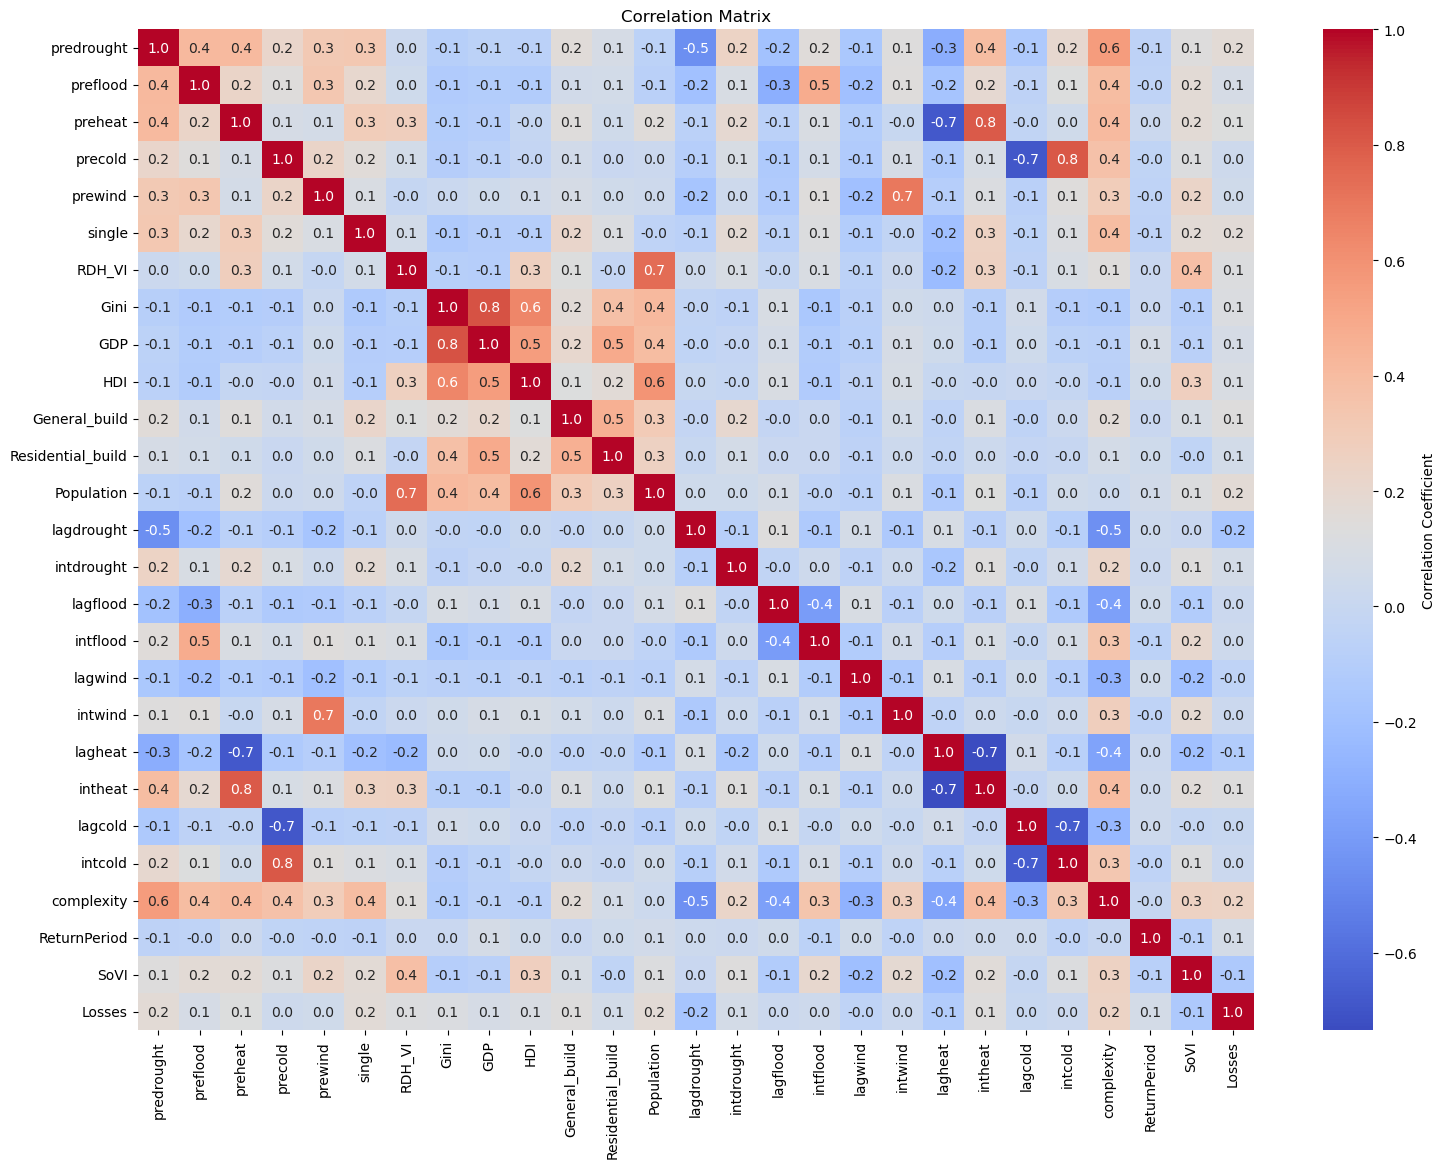

In [16]:
X_scaled_df = pd.DataFrame(X, columns=cols)

# Combine X and y into one DataFrame
combined_df = pd.concat([X_scaled_df, y], axis=1)

# Compute the correlation matrix
corr_matrix = combined_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(18, 13))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix')
plt.savefig("./plots/corrmart.png", dpi=300)
plt.show()


In [17]:
test_mse_results = []
train_mse_results = []
train_r2_results = []
test_r2_results = []
all_shap_values = []
allx = []
allpred = []
allarch = []
all_feature_importances = []
allnuts = []


param_dist = {
    'n_estimators': [50, 120],
    'max_depth': [2, 3, 4],
    'min_samples_split': [12, 24],
    'min_samples_leaf': [10, 16],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_features': [6, 'sqrt', 'log2'],
    'subsample': [0.7, 0.9]
}

# Perform 300 random train-test splits
n_splits = 300

for i in range(n_splits):
    # Split data for parameter tuning
    X_temp_train, X_val, y_temp_train, y_val, nuts_temp_train, nuts_val = train_test_split(X, y, nuts_ids, test_size=0.1, random_state=i)
    
    # Parameter search
    gbm = GradientBoostingRegressor(random_state=11)
    search = RandomizedSearchCV(
        gbm, 
        param_distributions=param_dist, 
        n_iter=10,  # You can adjust n_iter based on computational resources
        cv=3, 
        random_state=11,
        n_jobs=-1  # Use all available cores
    )
    search.fit(X_temp_train, y_temp_train)
    
    # Best parameters
    best_params = search.best_params_
    
    # Split data for evaluation
    X_train, X_test, y_train, y_test, nuts_train, nuts_test = train_test_split(X, y, nuts_ids, test_size=0.1, random_state=i)
    
    # Train with best parameters
    gbm_final = GradientBoostingRegressor(**best_params, random_state=11)
    gbm_final.fit(X_train, y_train)
    
    # Evaluate the model
    y_train_pred = gbm_final.predict(X_train)
    y_test_pred = gbm_final.predict(X_test)
    
    # Calculate MSE for train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Calculate R² for train and test sets
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_mse_results.append(train_mse)
    test_mse_results.append(test_mse)
    train_r2_results.append(train_r2)
    test_r2_results.append(test_r2)
    
    # Compute SHAP values for the test set
    explainer = shap.Explainer(gbm_final)
    shap_values = explainer.shap_values(X_test)
    all_shap_values.append((shap_values, nuts_test))
    allpred.append((y_test_pred, nuts_test))
    allx.append(X_test)
    
    pimp = permutation_importance(gbm_final, X_test, y_test, n_repeats=30, random_state=11, n_jobs=-1)
    all_feature_importances.append(pimp.importances_mean)
    allnuts.append(nuts_test)


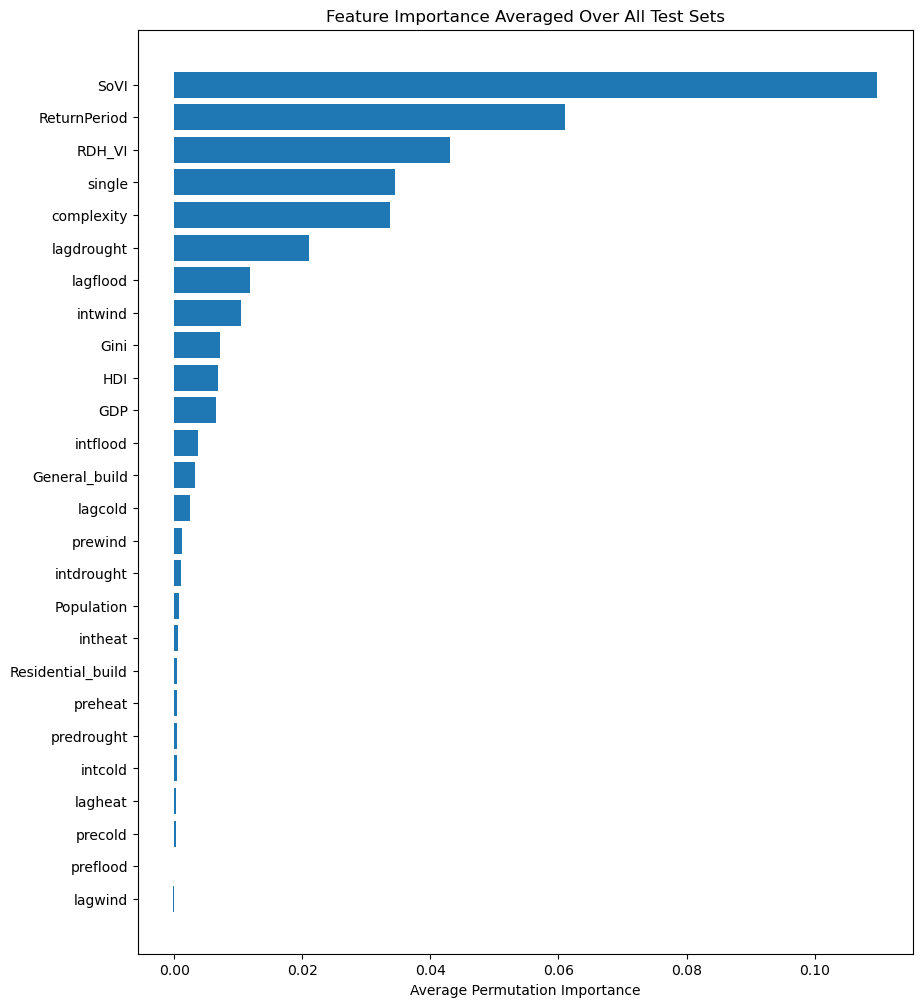

In [18]:
# Calculate the average feature importance over all splits
average_importance = np.mean(all_feature_importances, axis=0)

# Create a DataFrame to associate feature names with their importance
importance_df = pd.DataFrame({
    'Feature': cols,
    'Importance': average_importance
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the average feature importance, sorted by importance
plt.figure(figsize=(10, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Average Permutation Importance')
plt.title('Feature Importance Averaged Over All Test Sets')
plt.gca().invert_yaxis() 
plt.savefig('./plots/pimp.png', dpi=300, bbox_inches='tight')
plt.show()



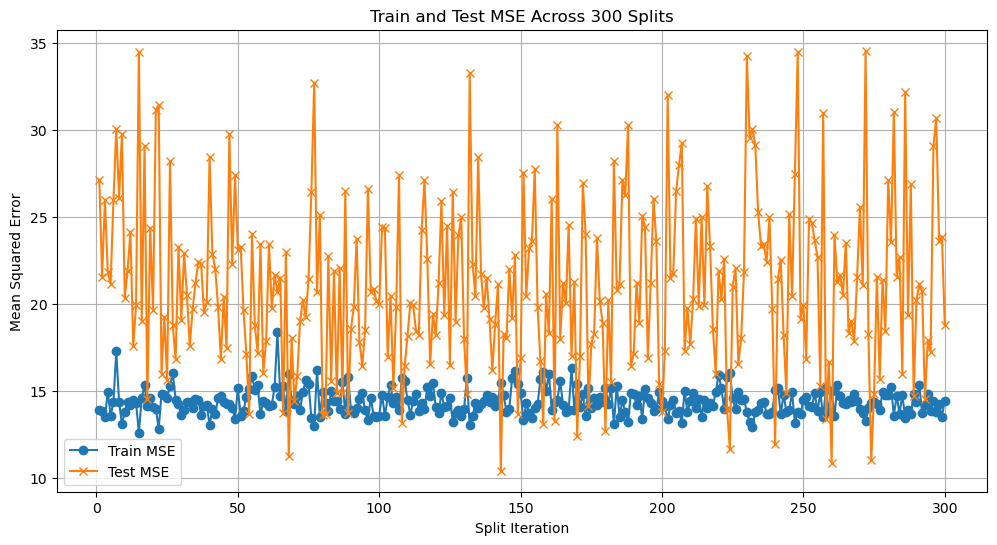

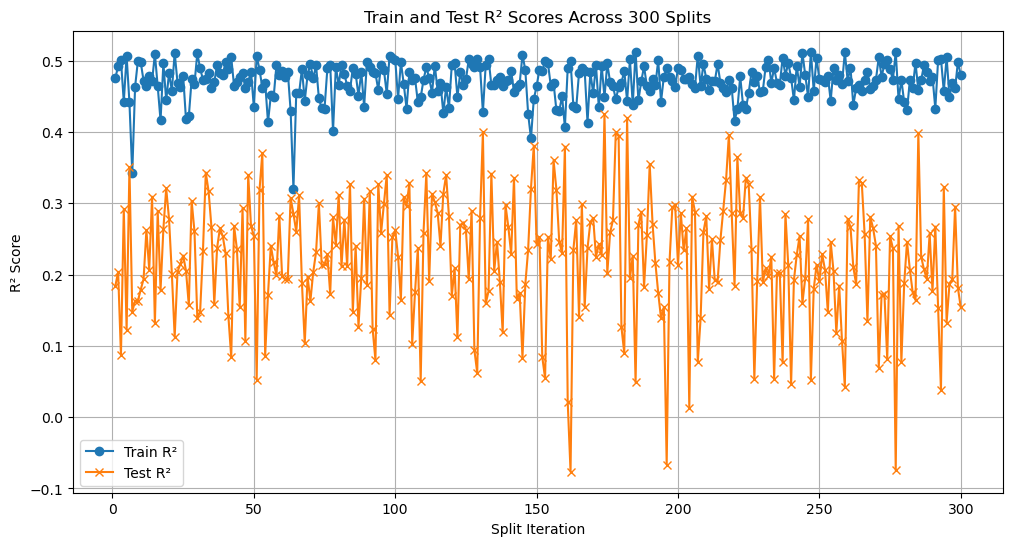

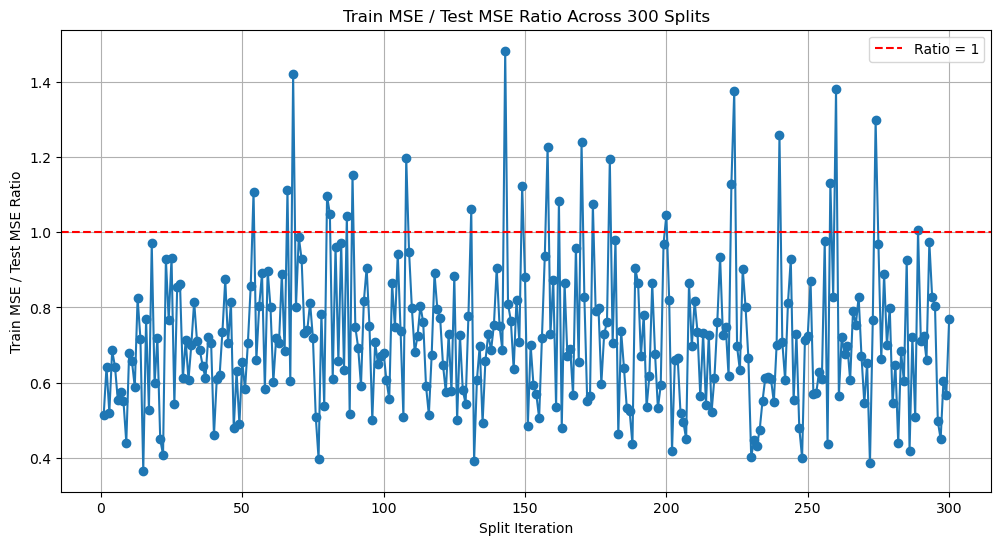

In [19]:

plt.figure(figsize=(12, 6))
plt.plot(range(1, n_splits + 1), train_mse_results, label='Train MSE', marker='o', linestyle='-')
plt.plot(range(1, n_splits + 1), test_mse_results, label='Test MSE', marker='x', linestyle='-')
plt.title('Train and Test MSE Across 300 Splits')
plt.xlabel('Split Iteration')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, n_splits + 1), train_r2_results, label='Train R²', marker='o', linestyle='-')
plt.plot(range(1, n_splits + 1), test_r2_results, label='Test R²', marker='x', linestyle='-')
plt.title('Train and Test R² Scores Across 300 Splits')
plt.xlabel('Split Iteration')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.savefig('../plots/r2.png', dpi=300, bbox_inches='tight')
plt.show()

ratios = np.array(train_mse_results) / np.array(test_mse_results)

plt.figure(figsize=(12, 6))
plt.plot(range(1, n_splits + 1), ratios, marker='o', linestyle='-')
plt.axhline(y=1, color='r', linestyle='--', label='Ratio = 1')
plt.title('Train MSE / Test MSE Ratio Across 300 Splits')
plt.xlabel('Split Iteration')
plt.ylabel('Train MSE / Test MSE Ratio')
plt.legend()
plt.grid(True)
plt.savefig('./plots/mseratio.png', dpi=300, bbox_inches='tight')
plt.show()


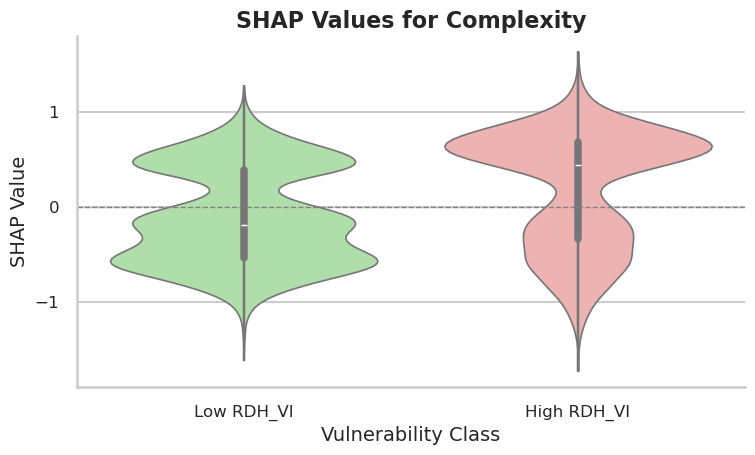

In [20]:

# Concatenate all SHAP values and corresponding test sets
shap_values_concat = np.concatenate([shap_tuple[0] for shap_tuple in all_shap_values], axis=0)
df_list = [pd.DataFrame(arr, columns=cols) for arr in allx]
x_concat = pd.concat(df_list, axis=0)

# Inverse transform the normalized data to get back the original RDH_VI values
x_original_scale = scaler.inverse_transform(x_concat)
x_original_scale_df = pd.DataFrame(x_original_scale, columns=cols)

# Add SHAP values for 'complexity' to the DataFrame
feature_names = cols
complexity_index = feature_names.index('complexity')
x_original_scale_df['complexity_shap'] = shap_values_concat[:, complexity_index]

# Create two groups based on the original scale of RDH_VI
low_vulnerability = x_original_scale_df[x_original_scale_df['RDH_VI'] < 4.5]
high_vulnerability = x_original_scale_df[x_original_scale_df['RDH_VI'] >= 4.5]

# Prepare the data for plotting
low_vulnerability['vulnerability_group'] = 'Low RDH_VI'
high_vulnerability['vulnerability_group'] = 'High RDH_VI'

# Combine the two groups
plot_data = pd.concat([low_vulnerability, high_vulnerability])


sns.set(style="whitegrid", context="talk", font_scale=1.2)

# Assign color palette manually
palette = {
    'Low RDH_VI': '#A8E6A2',   # light green
    'High RDH_VI': '#F7A8A8'   # light red
}

# Create the violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(
    x='vulnerability_group',
    y='complexity_shap',
    data=plot_data,
    palette=palette,
    inner='box',
    linewidth=1.2,
    cut=0
)

# Add horizontal line at 0 for reference
plt.axhline(0, linestyle='--', color='gray', linewidth=1)

# Refine labels and title
plt.title('SHAP Values for Complexity', fontsize=16, weight='bold')
plt.xlabel('Vulnerability Class', fontsize=14)
plt.ylabel('SHAP Value', fontsize=14)

# Tweak tick appearance
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines for clean look
sns.despine()

plt.tight_layout()
#plt.savefig("../plots/complrdh.png")
plt.show()

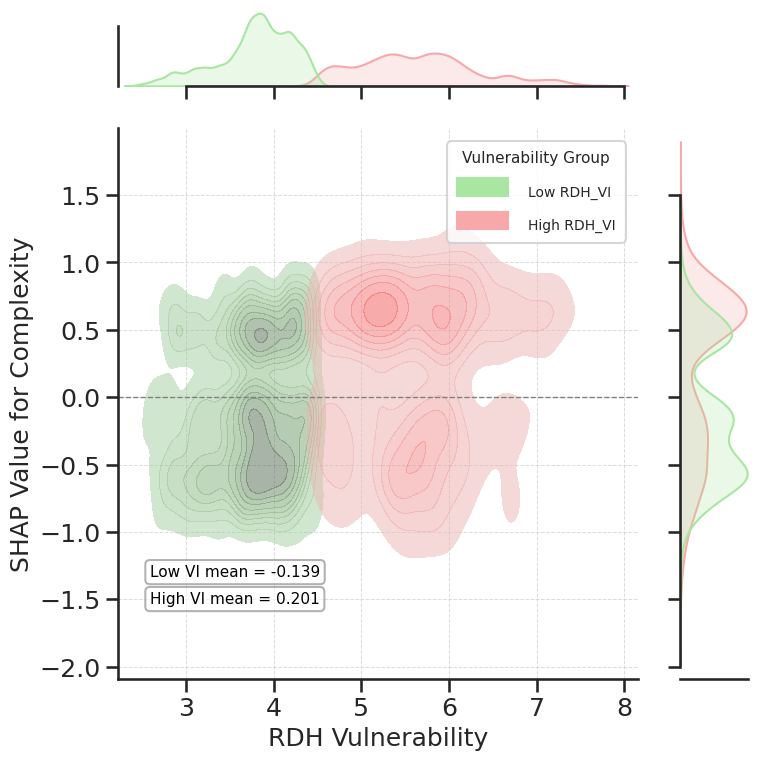

In [21]:

# Set the theme
sns.set_theme(style="ticks", context="talk", font_scale=1.1)

# Remove RDH_VI = 0 entries
plot_data = plot_data[plot_data.RDH_VI != 0]

# Create the joint KDE plot
g = sns.jointplot(
    data=plot_data,
    x="RDH_VI",
    y="complexity_shap",
    hue="vulnerability_group",
    kind="kde",
    fill=True,
    alpha=0.5,
    thresh=0.05,
    space=0,
    height=8,
    palette={
        'Low RDH_VI': '#A8E6A2',
        'High RDH_VI': '#F7A8A8'
    }
)

# Add grid to joint axis
g.ax_joint.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

# Set axis labels
g.set_axis_labels("RDH Vulnerability", "SHAP Value for Complexity", fontsize=18)

# Add horizontal reference line
g.ax_joint.axhline(0, linestyle="--", color="gray", linewidth=1)

# Remove spines from marginal plots
for ax in [g.ax_marg_x, g.ax_marg_y]:
    sns.despine(ax=ax, trim=True)

# Reduce legend font size
legend = g.ax_joint.get_legend()
legend.set_title("Vulnerability Group")
for text in legend.texts:
    text.set_fontsize(10)
legend.get_title().set_fontsize(11)

# Compute means
group_stats = plot_data.groupby('vulnerability_group')['complexity_shap'].mean()

# Place annotations in bottom-left corner
y_min = plot_data['complexity_shap'].min()
x_min = plot_data['RDH_VI'].min()
x_text = x_min + (plot_data['RDH_VI'].max() - x_min) * 0.02
y_base = y_min + (plot_data['complexity_shap'].max() - y_min) * 0.05

# Add each annotation with vertical spacing
for i, (group, mean_val) in enumerate(group_stats.items()):
    label = f"{'High' if 'High' in group else 'Low'} VI mean = {mean_val:.3f}"
    g.ax_joint.text(
        x_text,
        y_base + i * 0.20,  # space between lines
        label,
        fontsize=11,
        color='black',
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha=0.6)
    )

# Final layout
plt.tight_layout()
plt.savefig('./plots/shap_interact.png', dpi=600, bbox_inches='tight')

plt.show()


In [25]:
x_array = np.array(allx)
allshp, _ = list(zip(*all_shap_values))
#shap_array = np.array(all_shap_values)
shap_array = np.array(allshp)
#pred_array = np.array(allpred)

average_shap_values = np.mean(shap_array, axis=0)
#average_pred_values = np.mean(pred_array, axis=0)
allshap = shap_array.reshape((300*109, 26))
allxarr =x_array.reshape((300*109, 26))

In [26]:
shapdf = pd.DataFrame(allshap, columns=cols)

In [27]:

avg_abs_shap = shapdf.abs().mean()

# Calculate the average of positive SHAP contributions
avg_pos_shap = shapdf[shapdf > 0].mean()

# Combine these into a DataFrame for easy ranking and comparison
shap_summary = pd.DataFrame({
    'avg_abs_shap': avg_abs_shap,
    'avg_pos_shap': avg_pos_shap
})

# Calculate the percentage/fraction of each statistic
shap_summary['pct_avg_abs_shap'] = shap_summary['avg_abs_shap'] / shap_summary['avg_abs_shap'].sum() * 100
#shap_summary['pct_avg_shap'] = shap_summary['avg_shap'] / shap_summary['avg_shap'].sum() * 100
shap_summary['pct_avg_pos_shap'] = shap_summary['avg_pos_shap'] / shap_summary['avg_pos_shap'].sum() * 100

# Rank the features based on each statistic
shap_summary['rank_avg_abs_shap'] = shap_summary['avg_abs_shap'].rank(ascending=False)
#shap_summary['rank_avg_shap'] = shap_summary['avg_shap'].rank(ascending=False)
shap_summary['rank_avg_pos_shap'] = shap_summary['avg_pos_shap'].rank(ascending=False)



In [28]:
shap_summary.sort_values(by='rank_avg_pos_shap')

,avg_abs_shap,avg_pos_shap,pct_avg_abs_shap,pct_avg_pos_shap,rank_avg_abs_shap,rank_avg_pos_shap
complexity,0.509058,0.556116,10.815130,13.493469,4.0,1.0
ReturnPeriod,0.705947,0.510240,14.998134,12.380353,1.0,2.0
lagdrought,0.365536,0.435929,7.765957,10.577270,6.0,3.0
SoVI,0.556660,0.416806,11.826463,10.113284,2.0,4.0
RDH_VI,0.510913,0.358203,10.854548,8.691368,3.0,5.0
single,0.397779,0.317422,8.450968,7.701859,5.0,6.0
General_build,0.228330,0.191156,4.850972,4.638167,7.0,7.0
Gini,0.178261,0.169591,3.787217,4.114922,8.0,8.0
intwind,0.132288,0.152601,2.810504,3.702687,12.0,9.0
GDP,0.112471,0.122087,2.389482,2.962295,14.0,10.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

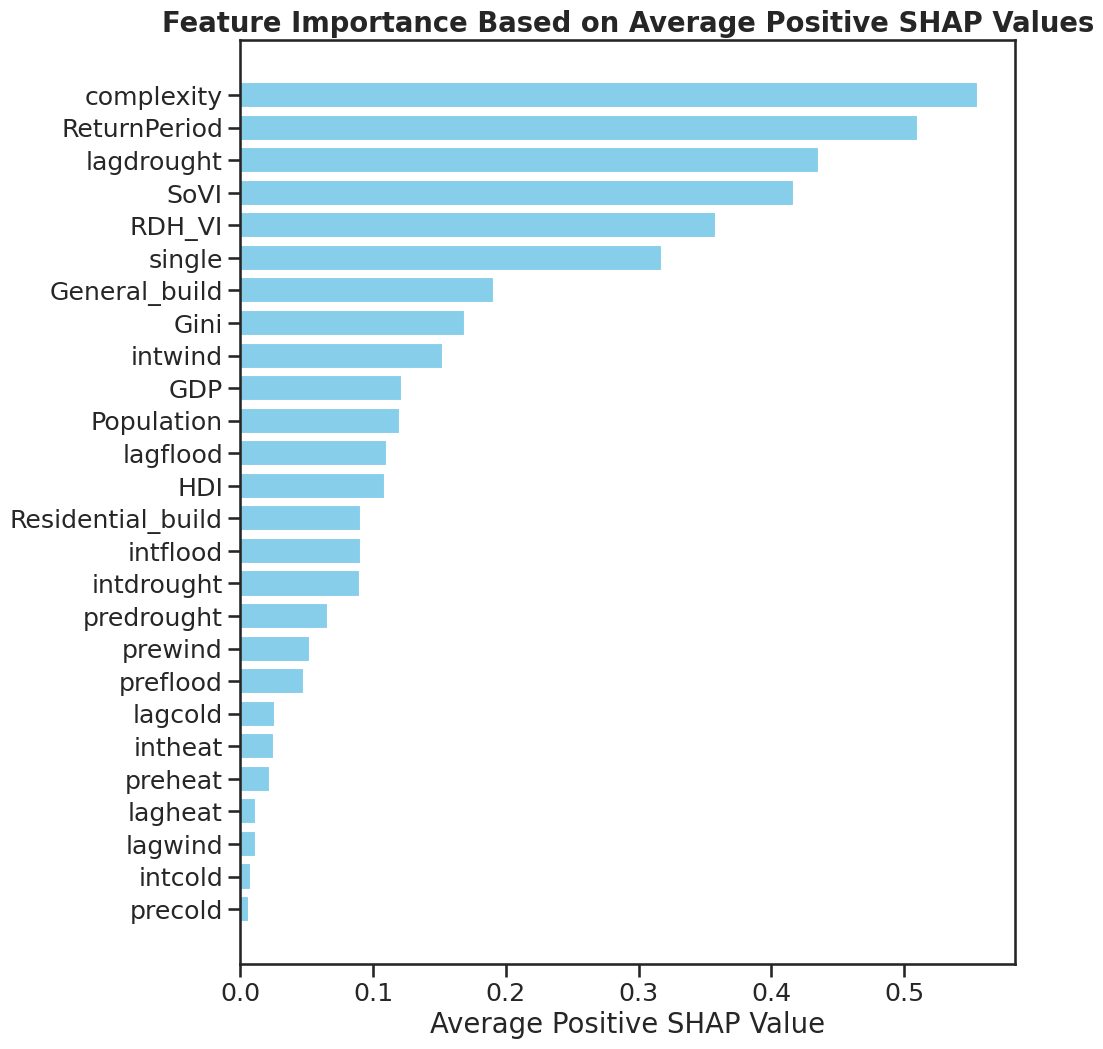

In [29]:

sorted_avg_pos_shap = avg_pos_shap.sort_values(ascending=False)

# Plot the sorted SHAP values
plt.figure(figsize=(10, 12))
plt.barh(sorted_avg_pos_shap.index, sorted_avg_pos_shap.values, color='skyblue')
plt.xlabel('Average Positive SHAP Value')
plt.title('Feature Importance Based on Average Positive SHAP Values')
plt.gca().invert_yaxis() 
plt.savefig('./plots/pshap.png', dpi=300, bbox_inches='tight')
plt.show()
 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

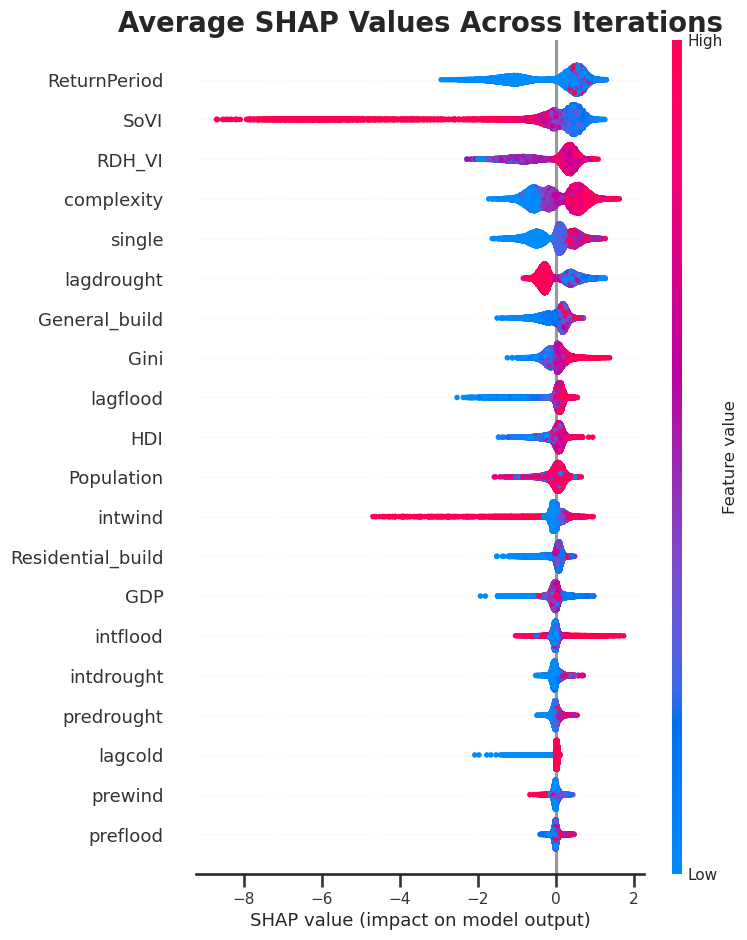

In [30]:
shap.summary_plot(allshap, allxarr, feature_names=cols, show=False)
plt.title("Average SHAP Values Across Iterations")
#plt.savefig("../plots/shap_pop.png")
plt.show()

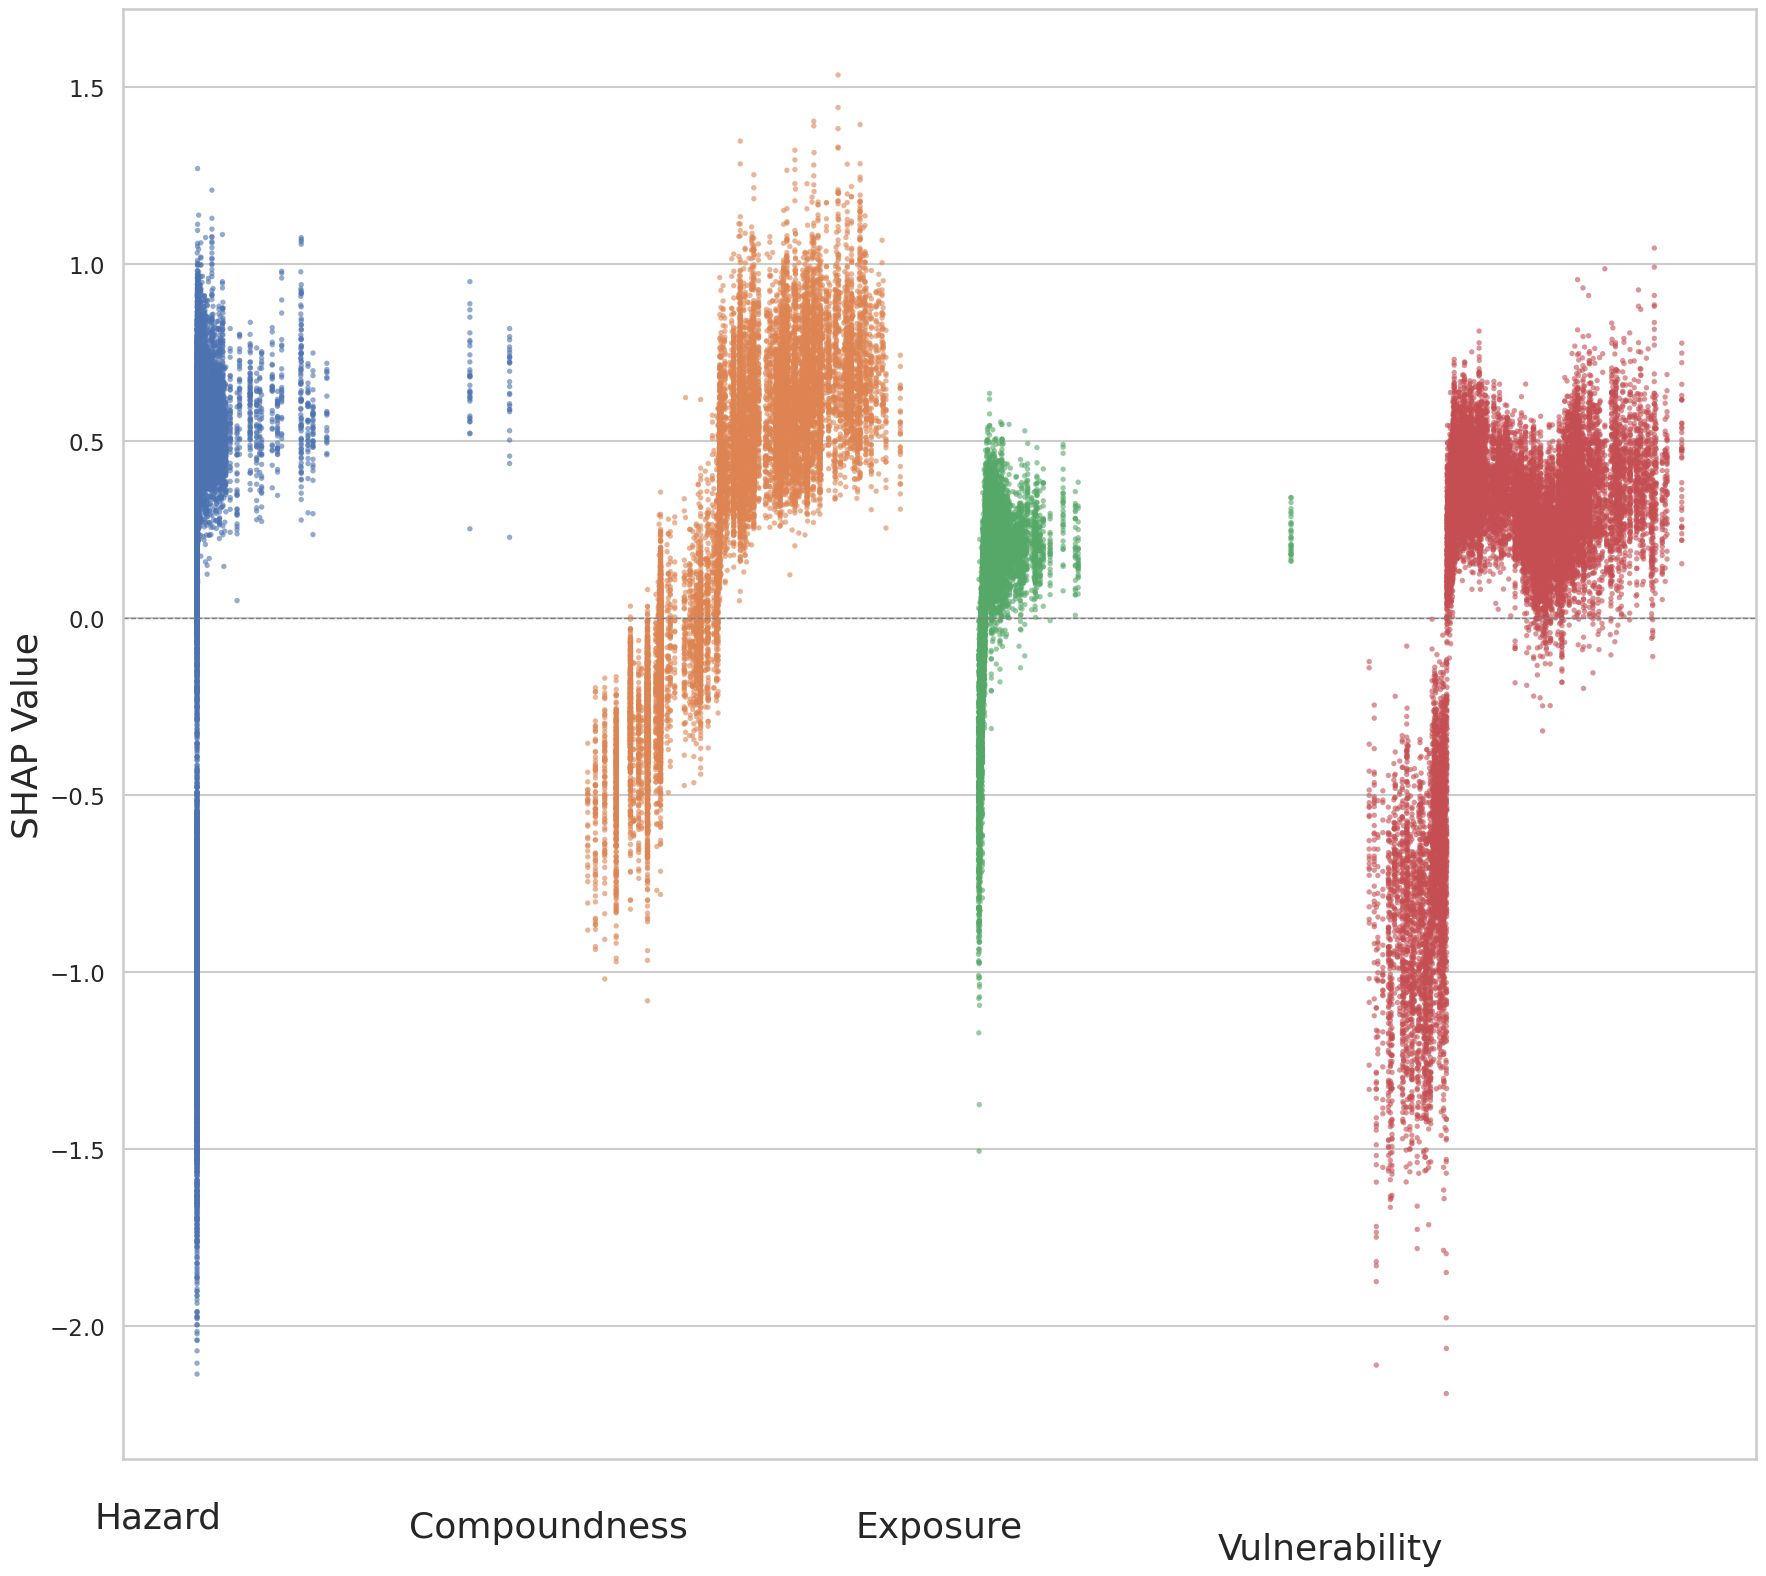

In [31]:

feat_map = {
    "ReturnPeriod":  "Hazard",
    "complexity":    "Compoundness",
    "General_build": "Exposure",
    "RDH_VI":        "Vulnerability"
}
features = list(feat_map.keys())
labels   = list(feat_map.values())
n_feats  = len(features)

# 1) Filter out rows where any selected feature == 0
sel_idx = [cols.index(f) for f in features]
mask    = np.all(allxarr[:, sel_idx] != 0, axis=1)
x_f = allxarr[mask]
s_f = allshap[mask]

# 2) Plot setup
sns.set_theme(style="whitegrid", context="talk")
palette    = sns.color_palette(n_colors=n_feats)
band_width = 0.8
margin     = (1 - band_width) / 2

plt.figure(figsize=(18, 16))

for i, feat in enumerate(features):
    idx   = cols.index(feat)
    xraw  = x_f[:, idx]
    y     = s_f[:, idx]

    # normalize to [0,1]
    xmin, xmax = xraw.min(), xraw.max()
    xnorm = (xraw - xmin) / (xmax - xmin)

    # scatter with higher transparency
    xscatter = i + margin + xnorm * band_width
    plt.scatter(
        xscatter, y,
        s=15, alpha=0.6,        # more transparent
        color=palette[i],
        edgecolor="none",       # avoid visual clutter
        zorder=2
    )

   
    # label each band center
    plt.text(
        i, plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.05,
        labels[i],
        fontsize=26,
        ha="center",
        va="top"
    )

# 3) Final polish
plt.xticks([], [])  # clear any x-ticks
plt.xlabel("")      # blank since we label below bands
plt.ylabel("SHAP Value", fontsize=26)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()


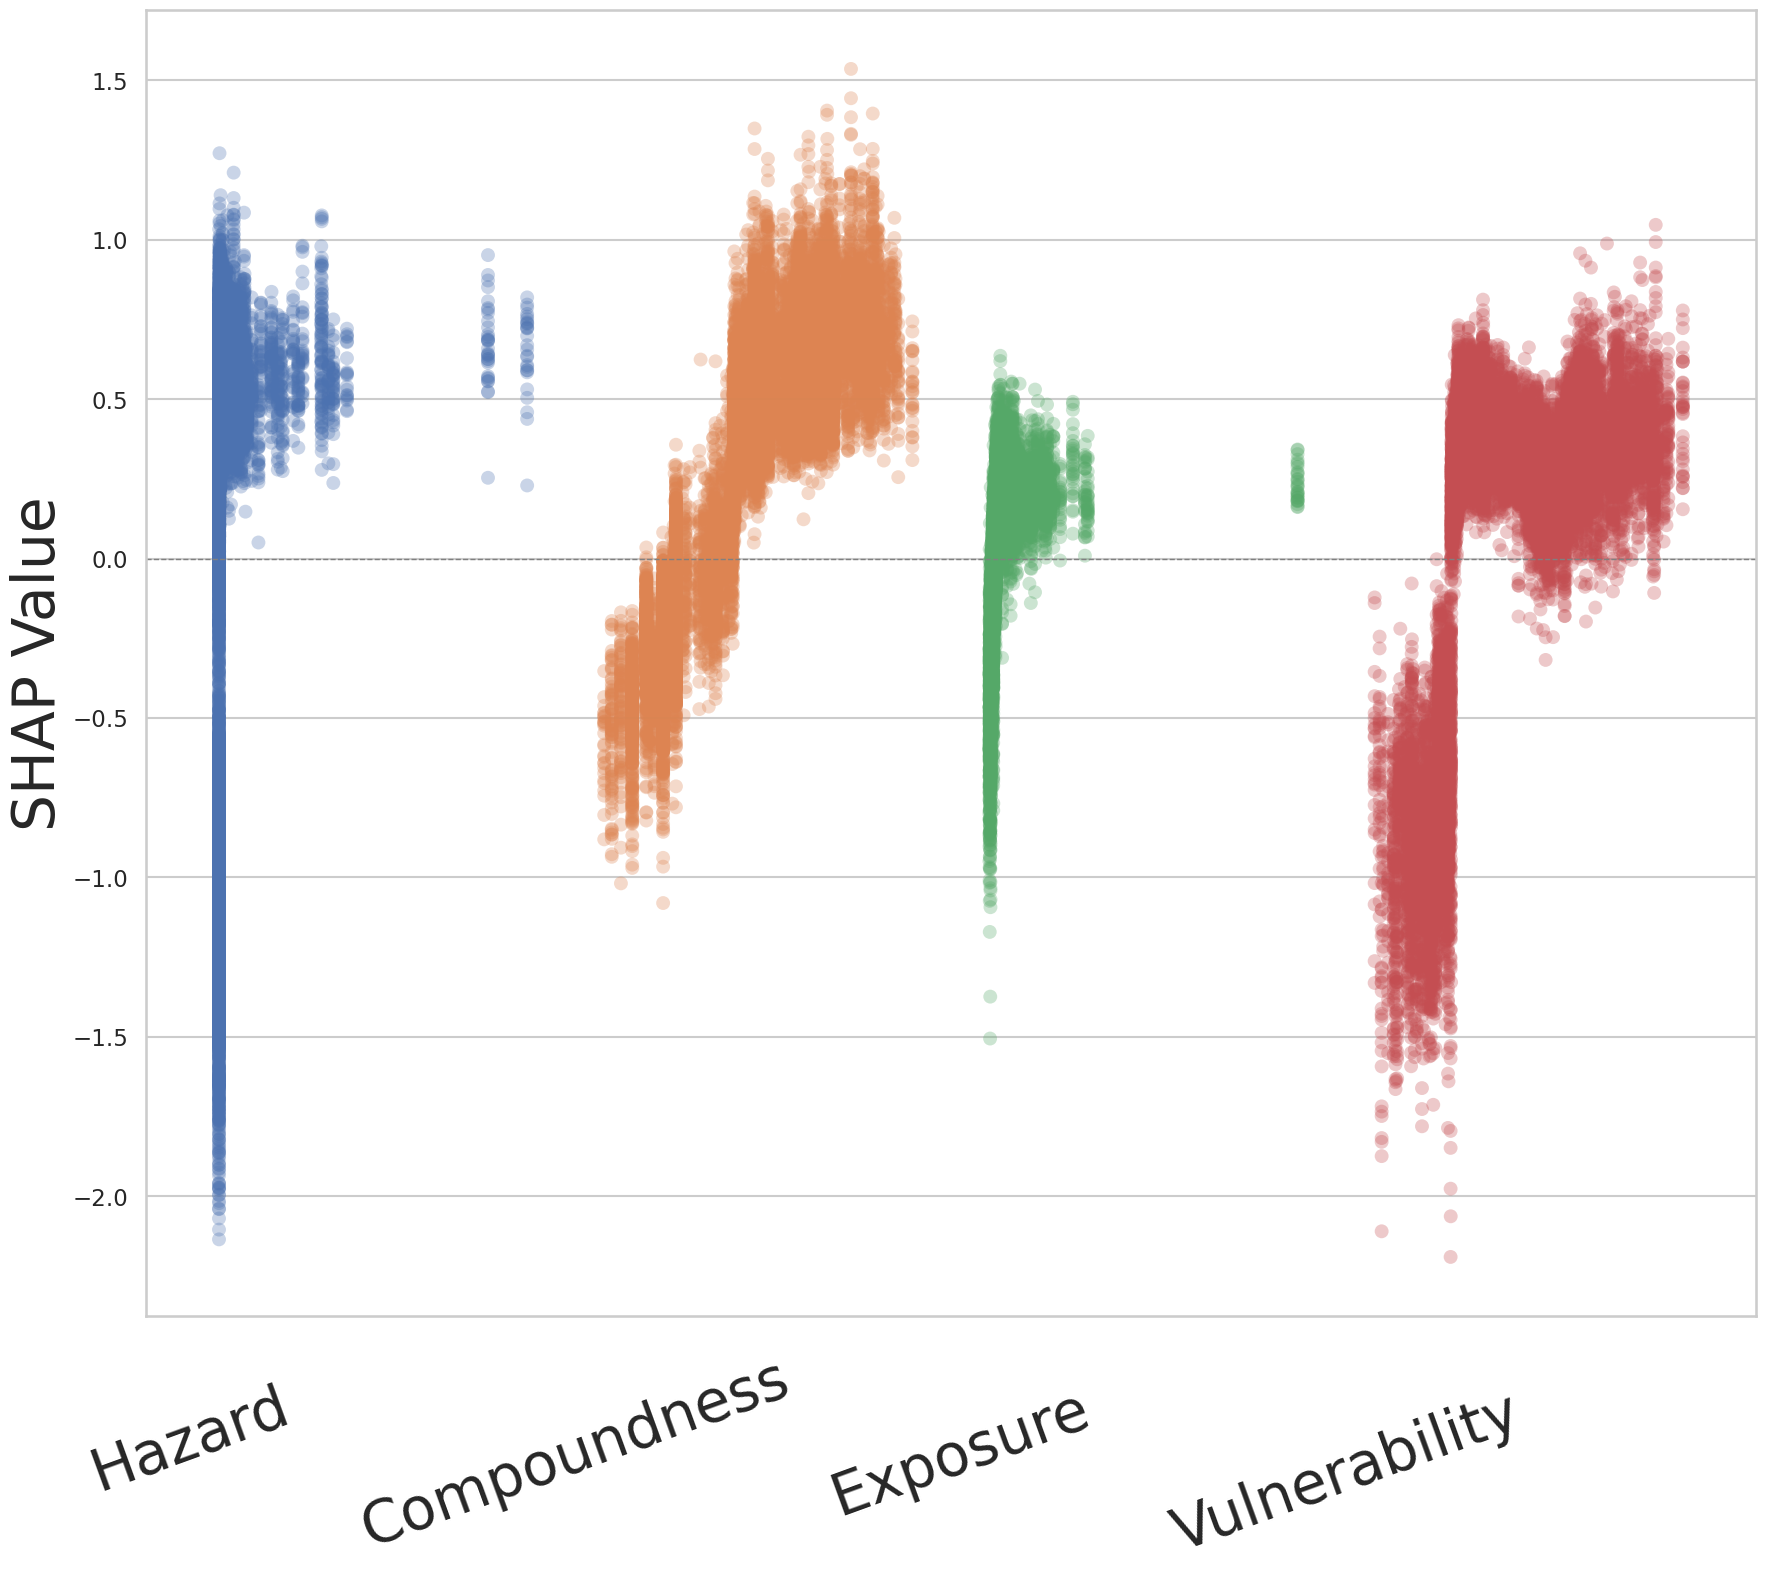

In [32]:

feat_map = {
    "ReturnPeriod":  "Hazard",
    "complexity":    "Compoundness",
    "General_build": "Exposure",
    "RDH_VI":        "Vulnerability"
}
features = list(feat_map.keys())
labels = list(feat_map.values())
n_feats = len(features)

# 1) Filter out rows where any selected feature == 0
sel_idx = [cols.index(f) for f in features]
mask = np.all(allxarr[:, sel_idx] != 0, axis=1)
x_f = allxarr[mask]
s_f = allshap[mask]

# 2) Plot setup
sns.set_theme(style="whitegrid", context="talk")
palette = sns.color_palette(n_colors=n_feats)
band_width = 0.8
margin = (1 - band_width) / 2

plt.figure(figsize=(18, 16))  # Adjust figure size as needed

for i, feat in enumerate(features):
    idx = cols.index(feat)
    xraw = x_f[:, idx]
    y = s_f[:, idx]

    # Normalize to [0,1]
    xmin, xmax = xraw.min(), xraw.max()
    xnorm = (xraw - xmin) / (xmax - xmin)

    # Scatter with larger markers and higher transparency
    xscatter = i + margin + xnorm * band_width
    plt.scatter(
        xscatter, y,
        s=100, alpha=0.3,  # Increase marker size
        color=palette[i],
        edgecolor="none",  # Avoid visual clutter
        zorder=2
    )

    # Label each band center with rotation
    plt.text(
        i, plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.1,  # Adjust label position
        labels[i],
        fontsize=42,  # Increase font size for labels
        ha="center",
        va="top",
        rotation=20,  # Rotate labels to fit better
        rotation_mode='anchor'
    )

# 3) Final polish
plt.xticks([], [])  # Clear any x-ticks
plt.xlabel("")  # Blank since we label below bands
plt.ylabel("SHAP Value", fontsize=42)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.tight_layout()  
plt.show()



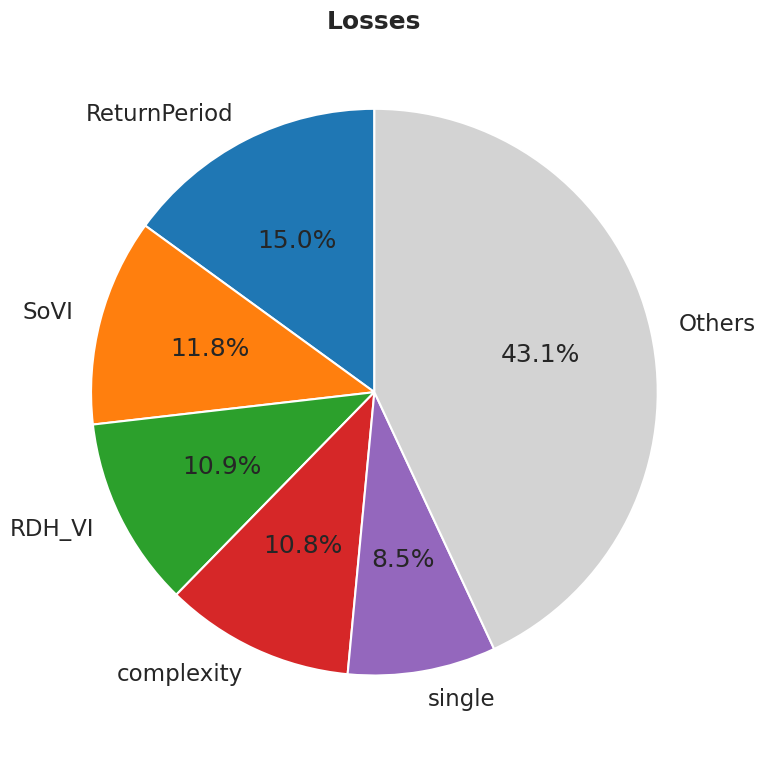

In [33]:

mean_abs_shap = np.mean(np.abs(allshap), axis=0)

# Step 2: Calculate the percentage importance of each feature
total_shap_sum = np.sum(mean_abs_shap)
percentage_importance = 100 * mean_abs_shap / total_shap_sum

# Step 3: Prepare data for visualization
# Identify the top five features
top_indices = np.argsort(percentage_importance)[-5:][::-1]
top_features = [(cols[i], percentage_importance[i]) for i in top_indices]

# Calculate the "Others" category
others_percentage = 100 - sum([importance for _, importance in top_features])
top_features.append(('Others', others_percentage))

# Step 4: Create a pie chart
labels, sizes = zip(*top_features)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#d3d3d3']  # Add colors for the features and others

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Losses')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()



In [34]:
X_scaled_df = pd.DataFrame(allxarr, columns=cols)
X_original_df = pd.DataFrame(scaler.inverse_transform(X_scaled_df), columns=X_scaled_df.columns)

In [ ]:
filtered_data = X_original_df[X_original_df['complexity'] != 0]
filtered_shap_values = allshap[filtered_data.index]

shap.dependence_plot("complexity", filtered_shap_values, filtered_data, interaction_index="RDH_VI")
feature_name = "complexity"

# Extract SHAP values for the feature of interest
complexity_shap_values = filtered_shap_values[:, filtered_data.columns.get_loc(feature_name)]

# Create a DataFrame with the feature values and SHAP values
shap_df = pd.DataFrame({
    feature_name: filtered_data[feature_name],
    'SHAP': complexity_shap_values
})



# Use Seaborn's lineplot with a 95% confidence interval
sns.lineplot(data=shap_df, x=feature_name, y='SHAP', ci=95)

plt.title(f'{feature_name} SHAP Values with Confidence Interval')
plt.xlabel(feature_name)
plt.ylabel('SHAP Value')
plt.grid(True)
plt.show()


In [42]:
features_of_interest = ["complexity"]
shap_long_df = pd.DataFrame()

for feature_name in features_of_interest:
    shap_values = allshap[:, filtered_data.columns.get_loc(feature_name)]
    
    temp_df = pd.DataFrame({
        'Feature': feature_name,
        'Feature Value': filtered_data[feature_name],
        'SHAP': shap_values
    })
    
    shap_long_df = pd.concat([shap_long_df, temp_df], ignore_index=True)


In [53]:
shap_long_df

,Feature,Feature Value,SHAP
0,complexity,6.730117e-01,-0.128276
1,complexity,1.141293e-08,-0.645578
2,complexity,1.609438e+00,0.700240
3,complexity,1.141293e-08,-0.793241
4,complexity,1.220607e+00,0.569127
...,...,...,...
32695,complexity,1.263654e+00,0.950859
32696,complexity,5.623352e-01,-0.498247
32697,complexity,1.220607e+00,0.590065
32698,complexity,1.060944e+00,0.606647


In [58]:
data = {
    'NUTS_ID': np.array(allnuts).flatten(),
    'complexity':X_original_df["complexity"].values,
    'SHAP_complexity': allshap[:,23]
}

df = pd.DataFrame(data)

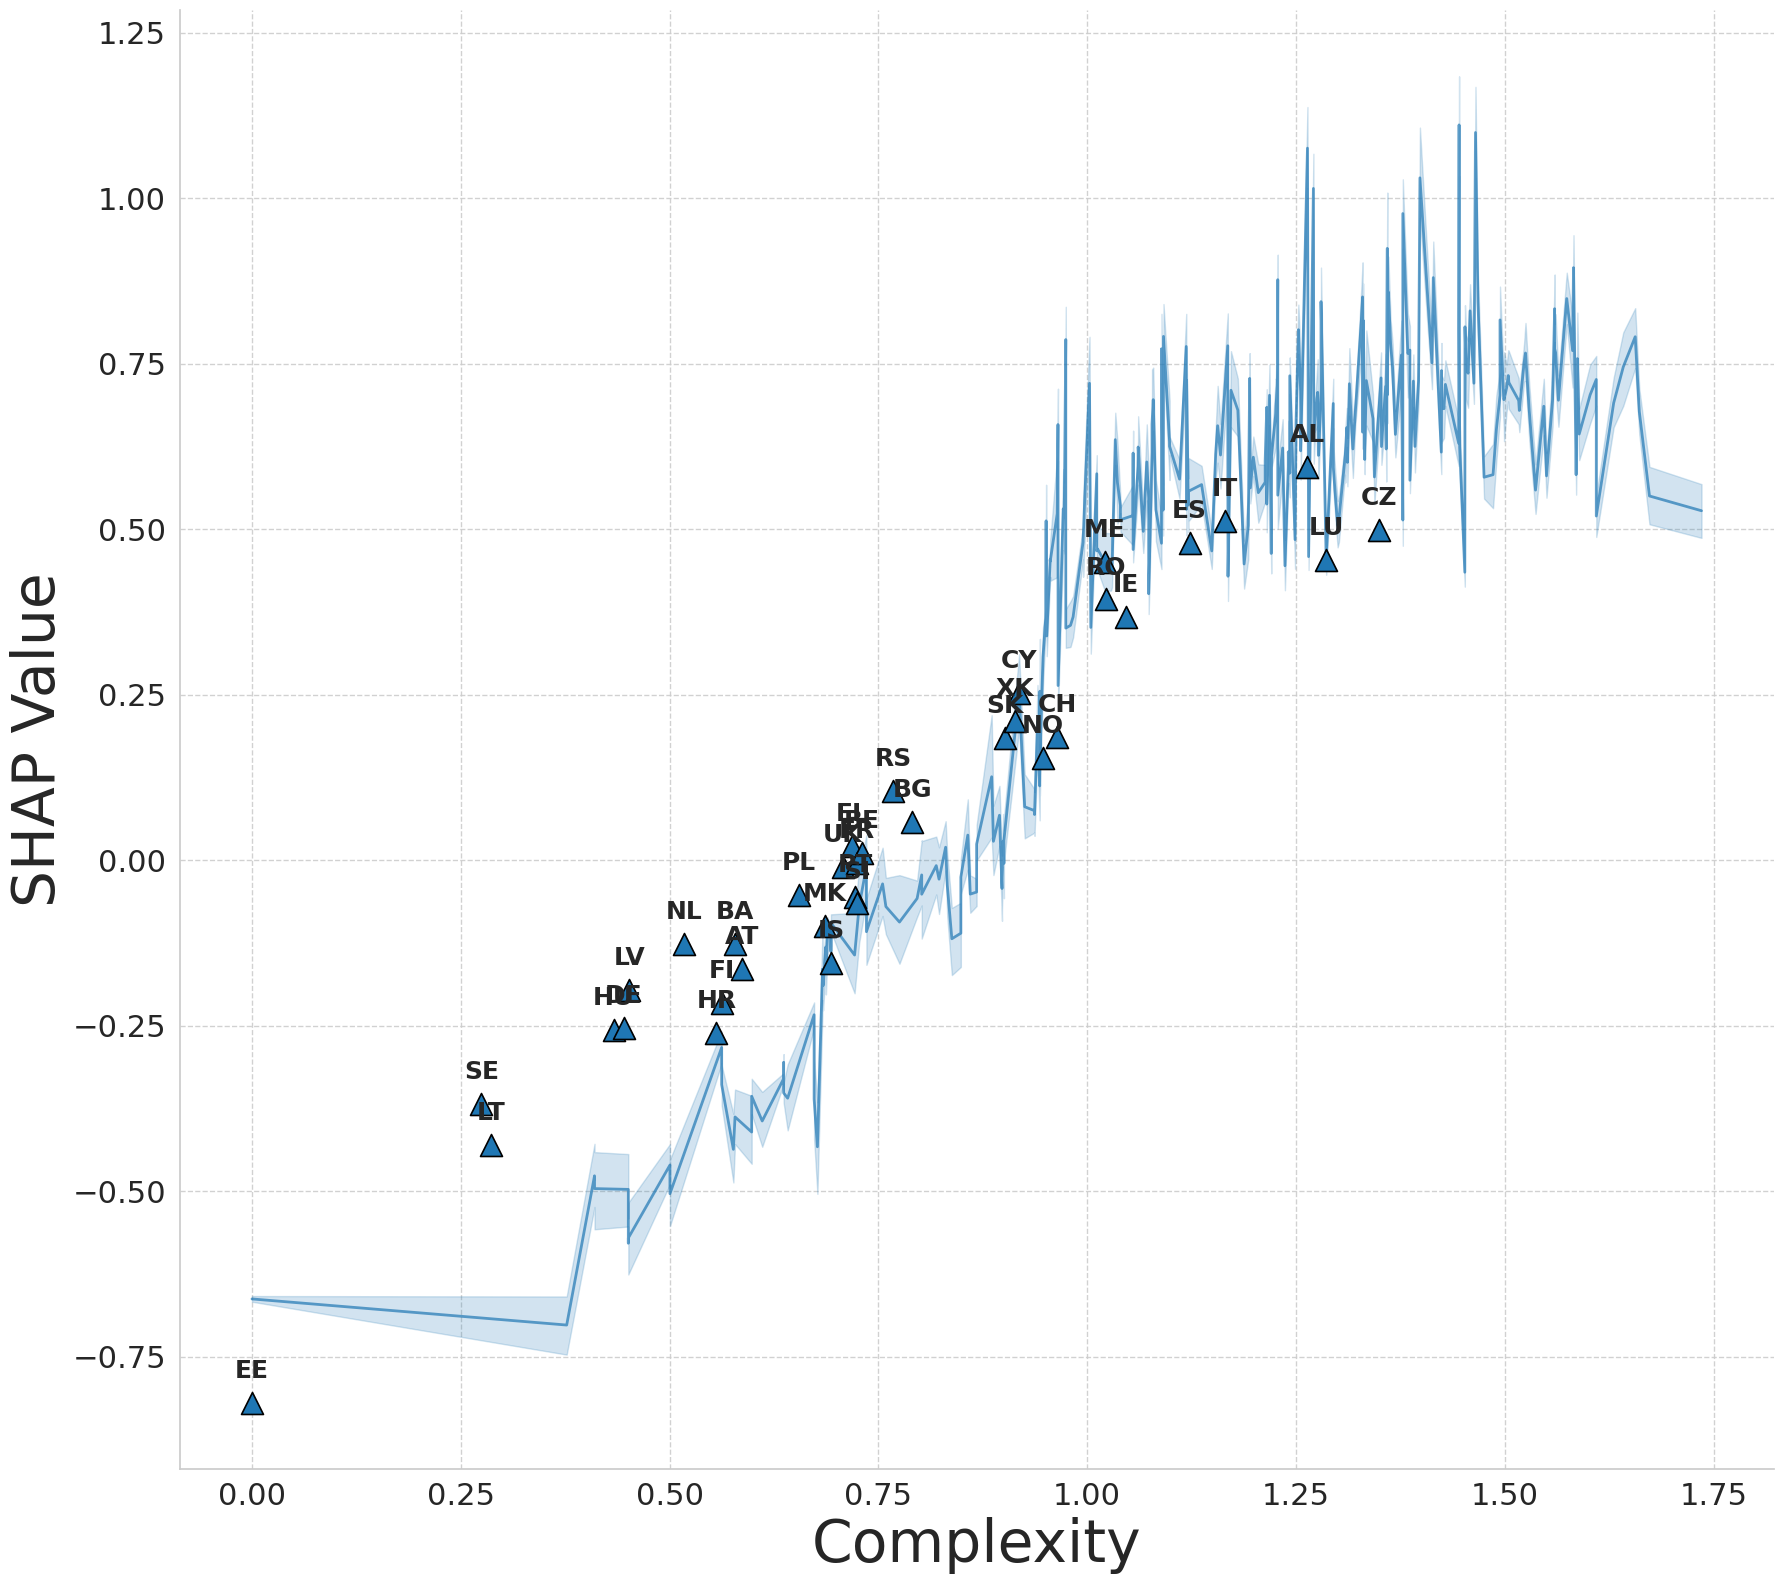

In [60]:

# Step 2: Compute and sort country-level averages
df['ISO'] = df['NUTS_ID'].str[:2]
iso_avg = df.groupby('ISO')[['SHAP_complexity', 'complexity']].mean().reset_index()
iso_avg = iso_avg.sort_values('complexity').reset_index(drop=True)  # Sort by x-axis

# Step 3: Plotting
plt.figure(figsize=(18, 16))  # Wider figure for more horizontal space
sns.set(style="whitegrid")
main_color = "#1f77b4"

# Lineplot
sns.lineplot(
    data=shap_long_df,
    x='Feature Value',
    y='SHAP',
    hue='Feature',
    palette={features_of_interest[0]: main_color},
    ci=95,
    linewidth=2,
    alpha=0.7
)

# Triangular scatter points (larger size)
plt.scatter(
    iso_avg['complexity'],
    iso_avg['SHAP_complexity'],
    color=main_color,
    marker='^',
    s=250,  # Bigger triangles
    edgecolor='black',
    linewidth=1.2,  # Thicker edges for triangles
    zorder=3,
    label='Country Mean'
)

# ISO2 labels all on top, with no overlap
for i, row in iso_avg.iterrows():
    plt.text(
        row['complexity'],
        row['SHAP_complexity'] + 0.03,  # Label offset on top
        row['ISO'],
        fontsize=18,  # Larger label size
        weight='bold',
        ha='center',
        va='bottom',
        zorder=4
    )

# Final polish
plt.xlabel('Complexity', fontsize=42)
plt.ylabel('SHAP Value', fontsize=42)
plt.xticks(fontsize=22)  # Increase x-tick label size
plt.yticks(fontsize=22)  # Increase y-tick label size
plt.grid(True, linestyle='--', linewidth=1.0, alpha=0.9)  # Thicker and more opaque grid
plt.legend([], [], frameon=False)
sns.despine()
plt.tight_layout()
#plt.savefig('../plots/shap_country.png', dpi=600, bbox_inches='tight')
plt.show()

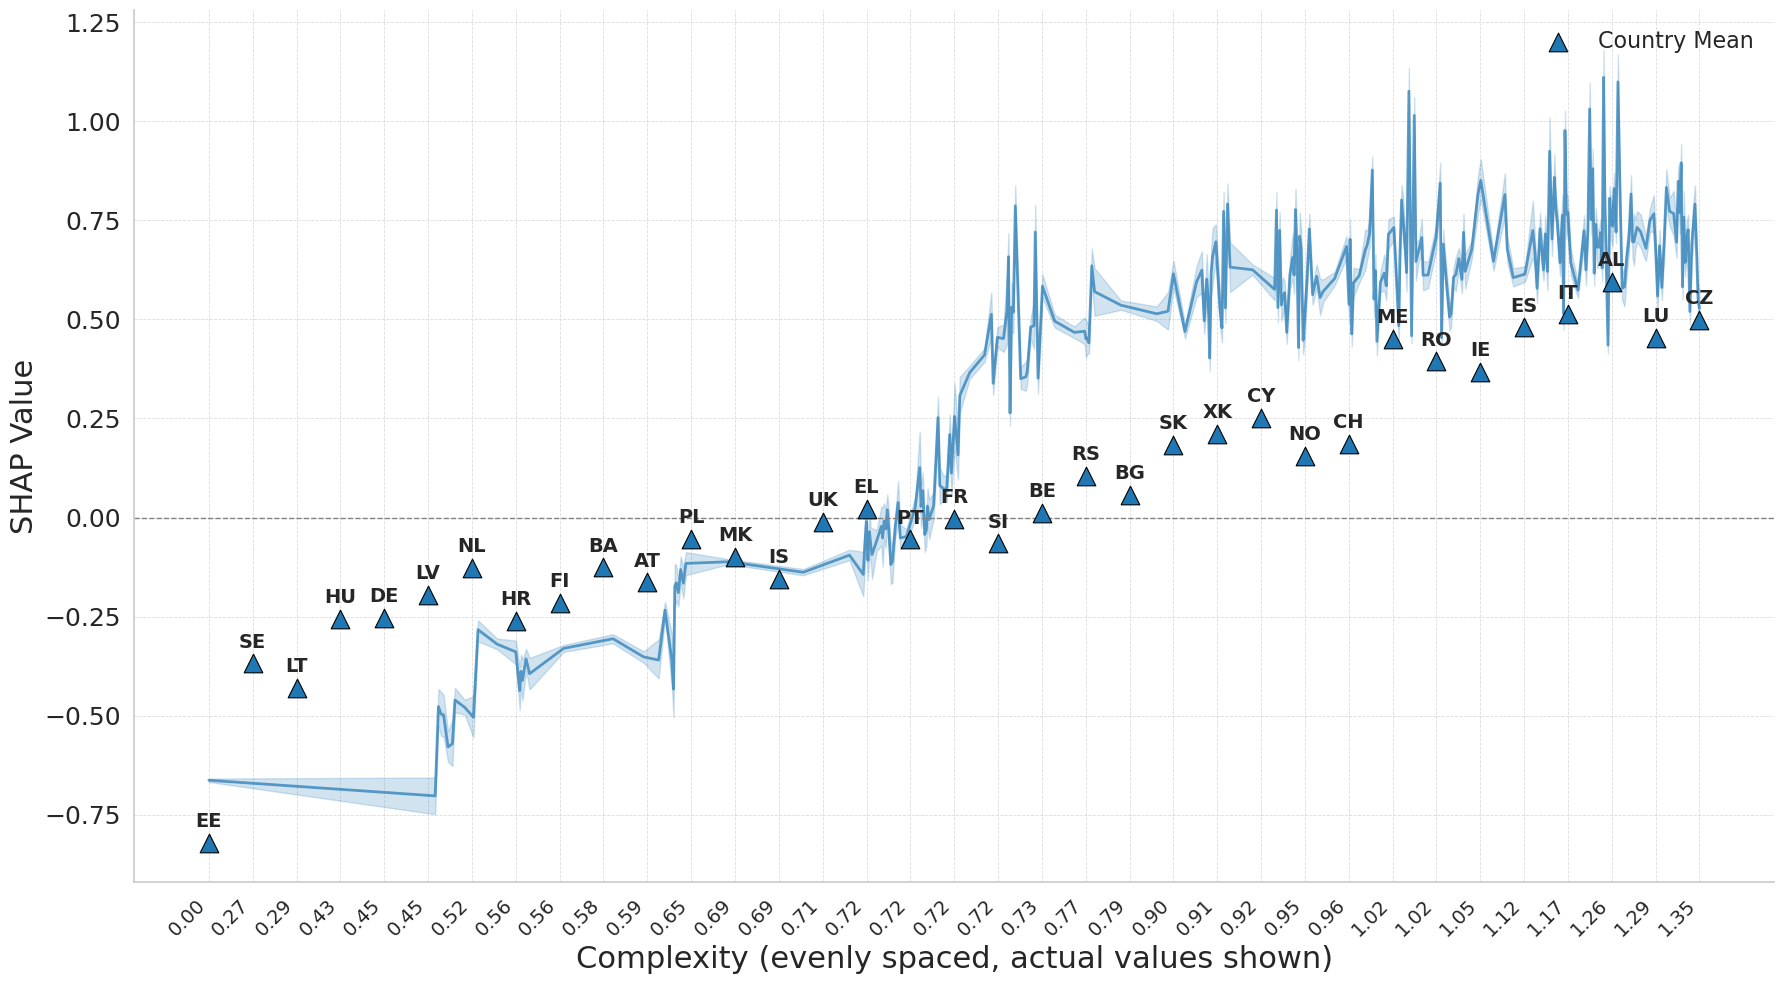

In [61]:

complexity_vals = filtered_data["complexity"].values
shap_vals = allshap[:, filtered_data.columns.get_loc("complexity")]

shap_df = pd.DataFrame({
    "complexity": complexity_vals,
    "SHAP": shap_vals
})

# 2) Country-level averages
df["ISO"] = df["NUTS_ID"].str[:2]
iso_avg = (
    df.groupby("ISO")[["complexity", "SHAP_complexity"]]
      .mean()
      .reset_index()
      .sort_values("complexity")
      .reset_index(drop=True)
)

# 3) Define evenly spaced "pseudo-x" values
n_countries = len(iso_avg)
min_c, max_c = iso_avg["complexity"].min(), iso_avg["complexity"].max()
pseudo_x_vals = np.linspace(min_c, max_c, n_countries)

# Assign pseudo-x to each country
iso_avg["pseudo_x"] = pseudo_x_vals

# 4) Now also transform the original data (shap_df) to this spacing scheme
# First: rank-transform complexity, then normalize ranks to [min_c, max_c]
shap_df["rank"] = shap_df["complexity"].rank(method="average")
shap_df["normalized_x"] = np.interp(
    shap_df["rank"],
    (shap_df["rank"].min(), shap_df["rank"].max()),
    (min_c, max_c)
)

# 5) Plotting
plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")
main_color = "#1f77b4"

# SHAP lineplot using normalized x
sns.lineplot(
    data=shap_df,
    x="normalized_x",
    y="SHAP",
    color=main_color,
    ci=95,
    linewidth=2,
    alpha=0.7,
    label='_nolegend_'
)

# Triangular country means on pseudo-x axis
plt.scatter(
    iso_avg["pseudo_x"],
    iso_avg["SHAP_complexity"],
    color=main_color,
    marker="^",
    s=180,
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Country Mean"
)

# Country ISO labels
for _, row in iso_avg.iterrows():
    plt.text(
        row["pseudo_x"],
        row["SHAP_complexity"] + 0.03,
        row["ISO"],
        fontsize=14,
        weight="bold",
        ha="center",
        va="bottom",
        zorder=4
    )

# Set ticks to actual pseudo-x values with 1 decimal precision
xticks = iso_avg["pseudo_x"].values
xticklabels = [f"{val:.2f}" for val in iso_avg["complexity"].values]
plt.xticks(xticks, xticklabels, fontsize=14, rotation=45, ha="right")

# Axis labels and grid
plt.xlabel("Complexity (evenly spaced, actual values shown)", fontsize=22)
plt.ylabel("SHAP Value", fontsize=22)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.legend(fontsize=16, frameon=False)
sns.despine()
plt.tight_layout()
plt.show()


In [35]:
X_scaled_df = pd.DataFrame(allxarr, columns=cols)
X_original_df = pd.DataFrame(scaler.inverse_transform(X_scaled_df), columns=X_scaled_df.columns)

In [36]:
filtered_data = X_original_df[X_original_df['complexity'] != 0]

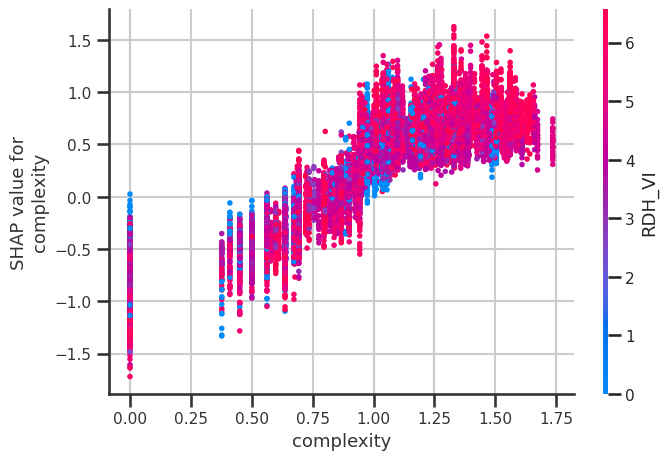

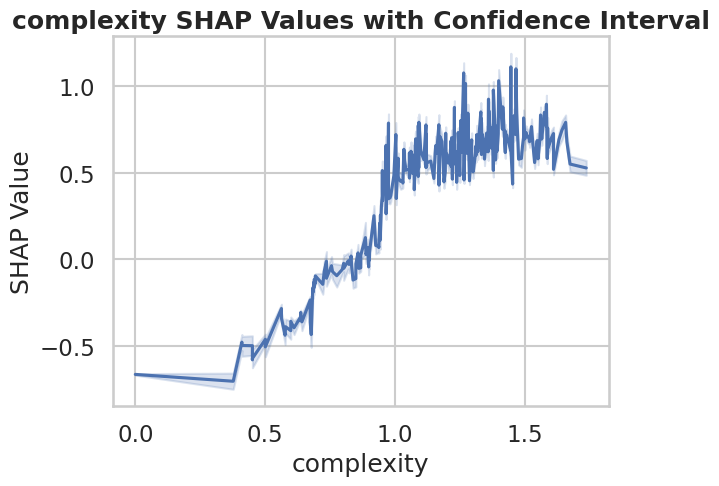

In [37]:
filtered_data = X_original_df[X_original_df['complexity'] != 0]
filtered_shap_values = allshap[filtered_data.index]

shap.dependence_plot("complexity", filtered_shap_values, filtered_data, interaction_index="RDH_VI")
feature_name = "complexity"

# Extract SHAP values for the feature of interest
complexity_shap_values = filtered_shap_values[:, filtered_data.columns.get_loc(feature_name)]

# Create a DataFrame with the feature values and SHAP values
shap_df = pd.DataFrame({
    feature_name: filtered_data[feature_name],
    'SHAP': complexity_shap_values
})



# Use Seaborn's lineplot with a 95% confidence interval
sns.lineplot(data=shap_df, x=feature_name, y='SHAP', ci=95)

plt.title(f'{feature_name} SHAP Values with Confidence Interval')
plt.xlabel(feature_name)
plt.ylabel('SHAP Value')
plt.grid(True)
plt.show()


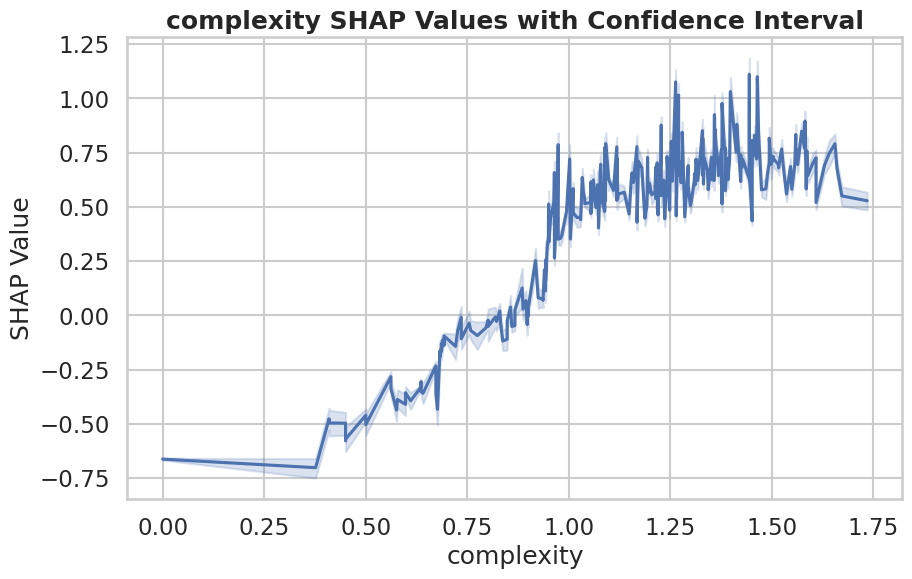

In [38]:

feature_name = "complexity"
complexity_shap_values = filtered_shap_values[:, filtered_data.columns.get_loc(feature_name)]
shap_df = pd.DataFrame({
    feature_name: filtered_data[feature_name],
    'SHAP': complexity_shap_values
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=shap_df, x=feature_name, y='SHAP', ci=95)

plt.title(f'{feature_name} SHAP Values with Confidence Interval')
plt.xlabel(feature_name)
plt.ylabel('SHAP Value')
plt.grid(True)
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

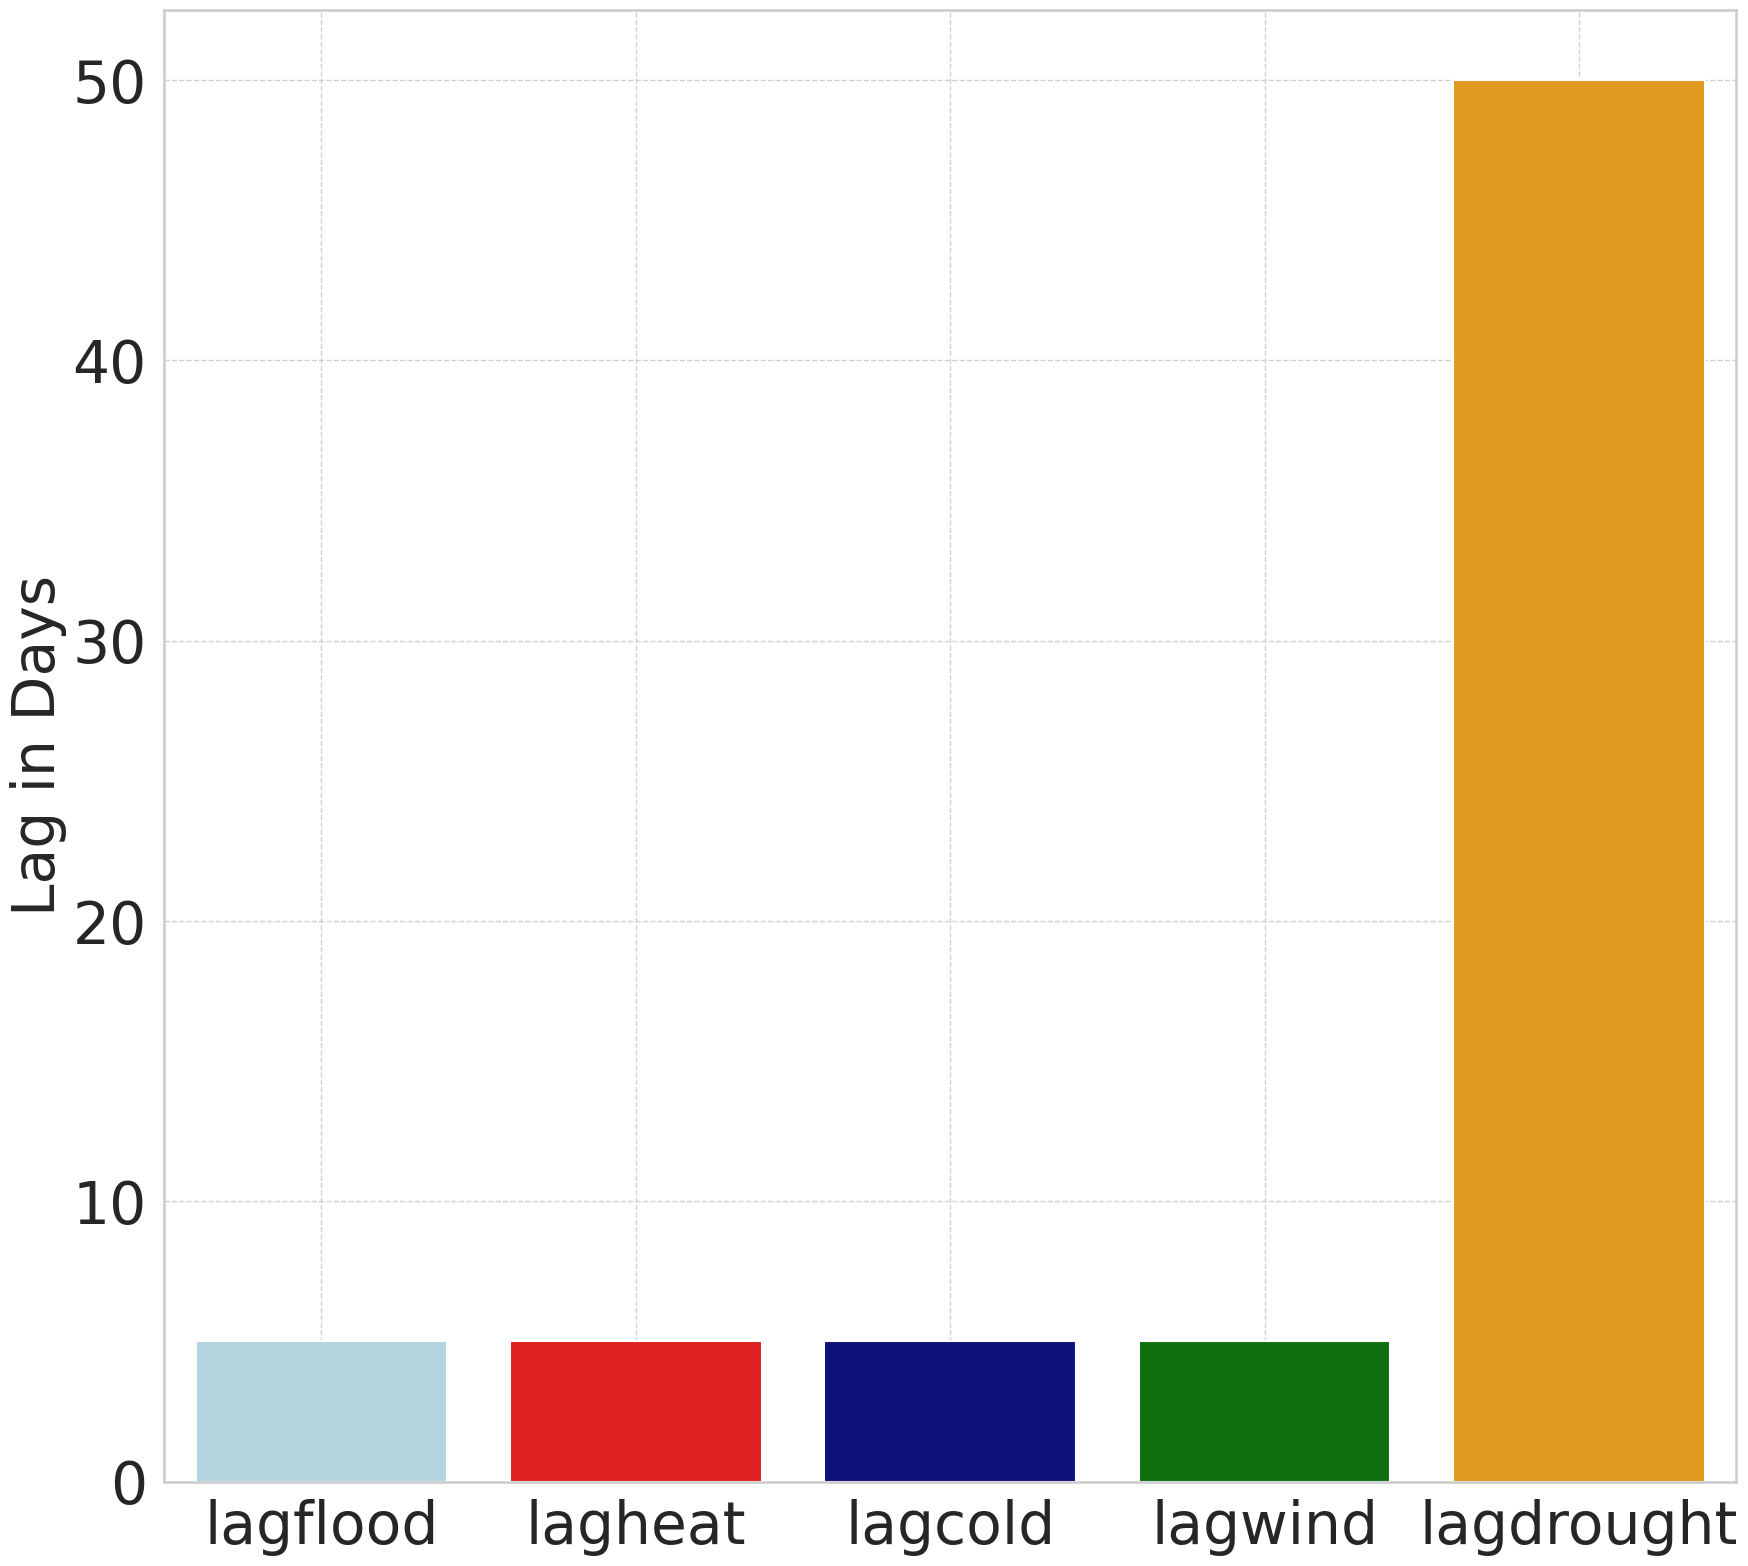

In [39]:

plt.rcParams['font.sans-serif'] = 'Arial'  # Specify the font, e.g., Arial
plt.rcParams['font.size'] = 18  # Set a default font size
plt.rcParams['axes.titleweight'] = 'bold'  # Set title weight
plt.rcParams['axes.labelweight'] = 'normal'  # Set label weight

feature_names = ["lagflood", "lagheat", "lagcold", "lagdrought", "lagwind"]
intervals = [(i, i + 10) for i in range(-55, 11, 5)]
max_intervals_mean_days = []

for feature_name in feature_names:
    complexity_shap_values = filtered_shap_values[:, filtered_data.columns.get_loc(feature_name)]
    shap_df = pd.DataFrame({
        feature_name: filtered_data[feature_name],
        'SHAP': complexity_shap_values
    })
    
    max_shap = float('-inf')
    max_interval_mean_days = None
    
    for start, end in intervals:
        # Filter rows within the current interval
        in_interval = shap_df[(shap_df[feature_name] >= start) & (shap_df[feature_name] < end)]
        # Calculate average SHAP value for the interval
        avg_shap = in_interval['SHAP'].mean()
        # Check if this is the maximum SHAP found so far
        if avg_shap > max_shap:
            max_shap = avg_shap
            max_interval_mean_days = (start + end) / 2
    
    # Store the feature and the mean days of the interval with the maximum SHAP value
    if max_interval_mean_days is not None:
        max_intervals_mean_days.append({'Feature': feature_name, 'Mean Days': abs(max_interval_mean_days)})

max_intervals_mean_days_df = pd.DataFrame(max_intervals_mean_days)
max_intervals_mean_days_df = max_intervals_mean_days_df.sort_values(by='Mean Days')

colors = {
    'lagflood': 'lightblue',
    'lagheat': 'red',
    'lagcold': 'darkblue',
    'lagdrought': 'orange',
    'lagwind': 'green'  # Example color for wind
}

plt.figure(figsize=(18, 16))
sns.barplot(
    data=max_intervals_mean_days_df, 
    x='Feature', 
    y='Mean Days', 
    palette=[colors[feature] for feature in max_intervals_mean_days_df['Feature']]
)

# Configure grid to include both horizontal and vertical lines
plt.grid(True, linestyle='--', linewidth=1.0, alpha=0.9)

# Set labels and ticks
plt.ylabel('Lag in Days', fontsize=42)
plt.xticks(fontsize=42)
plt.yticks(fontsize=42)
plt.xlabel('')

plt.tight_layout()
plt.savefig('./plots/shap_lags.png', dpi=600, bbox_inches='tight')
plt.show()

